# The wine dataset

For the second exercise we'll be revisiting the wine dataset.

## Data import

First import and explore.

In [1]:
from sklearn.datasets import load_wine
import pandas as pd

X, y = load_wine(return_X_y=True)

df = pd.DataFrame(X)
df['target'] = y
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


The boxplot is a great way of showing distributions. Show the boxplots for columns 1 through 12 in one graph.

<Axes: >

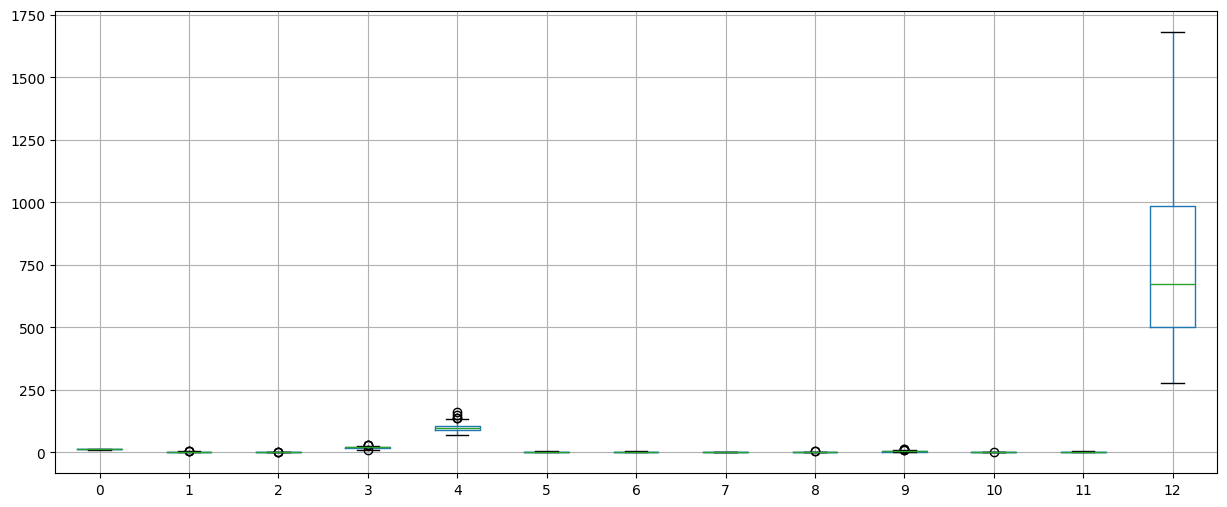

In [2]:
#DELETE
df.drop('target', axis=1).boxplot(figsize=(15, 6))

You'll see one normal boxplot, column 12, and 12 (0-11) very small ones.

## 2D clustering

Let's create a scatterplot of 2 vs 12. Use 'plt.axis('equal')' to make sure both axis have the same scaling. (Also comment the line away to compare.)

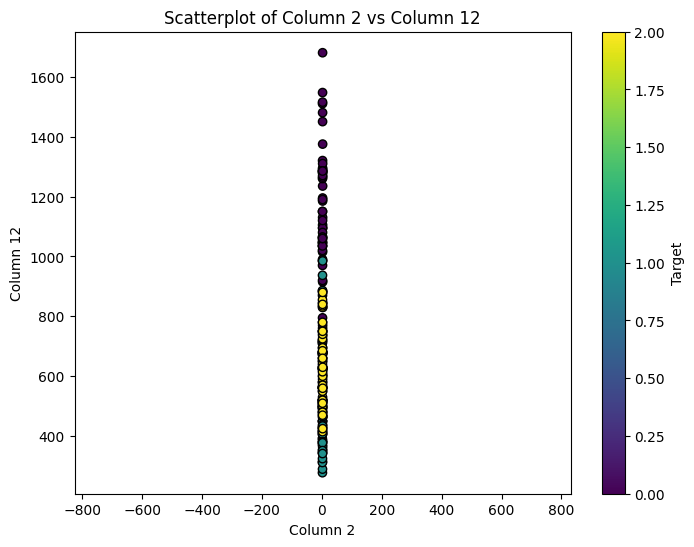

In [3]:
#DELETE
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df[2], df[12], c=df['target'], cmap='viridis', edgecolor='k')
plt.xlabel('Column 2')
plt.ylabel('Column 12')
plt.title('Scatterplot of Column 2 vs Column 12')
plt.colorbar(label='Target')
plt.axis('equal')  # Make x and y axes the same scale
plt.show()

Train a clustering model on this, unaltered data. Create three clusters.

In [4]:
#DELETE
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(df.drop('target', axis=1))


And now compare the predicted clusters and the actual groups in a crosstable.

In [5]:
#DELETE
df['kmeans_labels'] = labels

pd.crosstab(df['target'], df['kmeans_labels'], rownames=['True'], colnames=['Predicted'])

Predicted,0,1,2
True,,,
0,1,31,27
1,64,7,0
2,37,11,0


## Scaling

The solution is scaling. Apply this to the wine dataset. Copy the results in a new dataframe where you also drop the "kmeans_labels" you got before.

In [6]:
#DELETE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled.loc[:, 0:12] = scaler.fit_transform(df.loc[:, 0:12])
df_scaled.drop('kmeans_labels', axis=1, inplace=True)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,target
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009,0
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242,0
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148,0
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574,0
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874,0


Now recreate the scatter plot from before. Does it still matter if you ask the model to equally scale the axis?

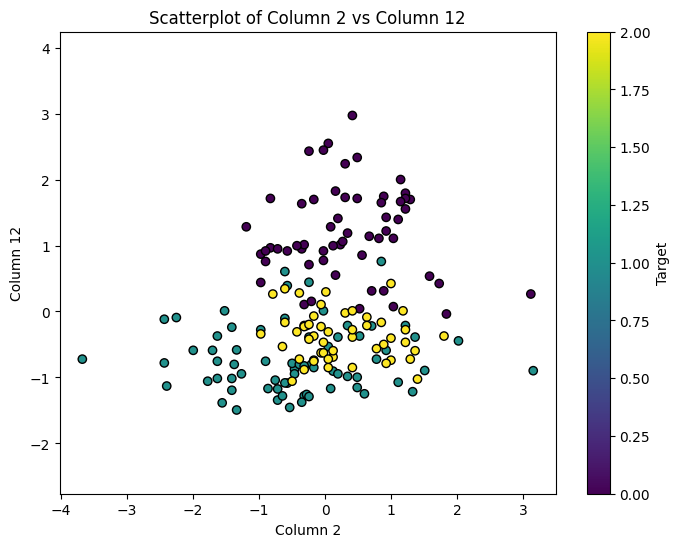

In [7]:
#DELETE
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_scaled[2], df_scaled[12], c=df_scaled['target'], cmap='viridis', edgecolor='k')
plt.xlabel('Column 2')
plt.ylabel('Column 12')
plt.title('Scatterplot of Column 2 vs Column 12')
plt.colorbar(label='Target')
plt.axis('equal')  # Make x and y axes the same scale
plt.show()

In [8]:
#DELETE
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(df_scaled.drop('target', axis=1))


Also create a crosstable to compare.

In [9]:
df_scaled['kmeans_labels'] = labels

pd.crosstab(df_scaled['target'], df_scaled['kmeans_labels'], rownames=['True'], colnames=['Predicted'])

Predicted,0,1,2
True,,,
0,0,0,59
1,65,3,3
2,0,48,0


That's more like it.

## Inference

Using the following row, we'll randomly select three rows from the original dataset.

In [10]:
sampled_df = df.groupby('target').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)
sampled_df

C:\Users\Jochen\AppData\Local\Temp\ipykernel_11492\2466638621.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('target').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)


,0,1,2,3,4,5,6,7,8,9,10,11,12,target,kmeans_labels
0,14.23,1.71,2.43,15.6,127.0,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,1
1,12.72,1.81,2.20,18.8,86.0,2.2,2.53,0.26,1.77,3.90,1.16,3.14,714.0,1,0
2,12.45,3.03,2.64,27.0,97.0,1.9,0.58,0.63,1.14,7.50,0.67,1.73,880.0,2,1


We won't be using the first model, as it's bad, so let's see where these end up using the second model?

In [11]:
#DELETE
# Predict cluster labels using the fitted kmeans model
predicted_labels = kmeans.predict(sampled_df.drop('target', axis=1).drop('kmeans_labels', axis=1))
predicted_labels

array([2, 2, 2], dtype=int32)

It appears they are all of the second group. But are they?

They are not. The data we are using for inference is unscaled, where the data we used to train the model was scaled. The problem is if we simply reapply the scaler to this data, it uses different parameters. Let's try it anyway:

In [12]:
#DELETE
from sklearn.preprocessing import StandardScaler

new_scaler = StandardScaler()
df_scaled_sample = sampled_df.copy()
df_scaled_sample.loc[:, 0:12] = new_scaler.fit_transform(sampled_df.loc[:, 0:12])
df_scaled_sample.drop('kmeans_labels', axis=1, inplace=True)
df_scaled_sample.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,target
0,1.400139,-0.788792,0.037101,-1.013693,1.36589,1.336306,0.940910,-0.647432,1.183891,-0.027212,0.399604,1.092340,1.246235,0
1,-0.527712,-0.622145,-1.242874,-0.347155,-1.00037,-0.267261,0.443884,-0.765147,0.077981,-1.210912,0.975033,0.231708,-1.202059,1
2,-0.872427,1.410937,1.205773,1.360849,-0.36552,-1.069045,-1.384794,1.412580,-1.261872,1.238124,-1.374637,-1.324049,-0.044176,2


If we compare this data, we get the following table:

| Dataframe | Old value | New value |
| -----|-----|-----|
| Original | 1065.0 | 1.013009 |
| Original | 735.0 | -0.037874	|
| Sample | 1065.0 | 1.246235 |
| Sample | 714.0 | -1.202059 |

We have to use the original scaler. If you used the same variable to store the scaler you've made for the samples you have to retrain it on the original data. If not you can use the transform-method on the original scaler.

In [13]:
#DELETE
df_scaled_sample = scaler.transform(sampled_df.drop('target', axis=1).drop('kmeans_labels', axis=1))
cluster = kmeans.predict(df_scaled_sample)
print("Predicted cluster:", cluster)
sampled_df['kmeans_labels'] = cluster
sampled_df
pd.crosstab(sampled_df['target'], cluster, rownames=['True'], colnames=['Predicted'])


Predicted cluster: [2 0 1]


Predicted,0,1,2
True,,,
0,0,0,1
1,1,0,0
2,0,1,0


## Exporting

Scaling, although very beneficial for our model, adds an extra step in inference. It also requires us to export our scaler as well as our model when we want to deploy this model.

In [14]:
import joblib

joblib.dump(scaler, '../exports/scaler.pkl')
joblib.dump(kmeans, '../exports/kmeans_model.pkl')

['exports/kmeans_model.pkl']

And how would inferencing work now?

In [15]:
import joblib
# Load model and scaler if needed
scaler = joblib.load('../exports/scaler.pkl')
kmeans = joblib.load('../exports/kmeans_model.pkl')

# New sample(s), e.g., a NumPy array or DataFrame
X_new = [[13.2, 2.7, 2.5, 16.0, 100.0, 2.8, 3.2, 0.3, 2.1, 5.0, 1.1, 2.6, 1200.0]]

# Apply the SAME scaling
X_new_scaled = scaler.transform(X_new)

# Predict cluster
cluster = kmeans.predict(X_new_scaled)
print("Predicted cluster:", cluster)

Predicted cluster: [2]


Try restarting the jupyter-kernel to remove all existing variables. It should still work!